In [1]:
import numpy as np
import pandas as pd
from glob import glob
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import matplotlib.dates as mdates
import time
pandarallel.initialize()


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [408]:
plt.style.use('MNRAS_stylesheet')

In [344]:
#######################################
###                                 ###
###   STEP 1: Read and clean data   ###
###                                 ###
#######################################

class datacleaner():
    def __init__(self):
        tstart=time.time()
        # Get list of all files
        flist = glob('./MSFT/*csv')
        # Parallel read the files
        dfs= Parallel(n_jobs=8)(delayed(pd.read_csv)(i) for i in flist)
        print("Lengths",[len(w) for w in dfs])
        total_length1 = np.sum([len(w) for w in dfs])
        print(np.round(time.time()-tstart,2),"Read data")
        # Select only exchange "Q"
        dfs= Parallel(n_jobs=8)(delayed(self.select_exchange)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Selected on exchange")
        total_length2 = np.sum([len(w) for w in dfs])
        # Drop corrected
        dfs= Parallel(n_jobs=8)(delayed(self.drop_corr)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Dropped corrected")
        total_length3 = np.sum([len(w) for w in dfs])
        # Aggregate to second level(otherwise things are way too slow)
        dfs= Parallel(n_jobs=8)(delayed(self.to_seconds)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Made seconds from millisecond data")
        total_length4 = np.sum([len(w) for w in dfs])
        # Group by datetime (sum of sizes and median of prices)
        dfs= Parallel(n_jobs=8)(delayed(self.aggregate)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Grouped by datetime")
        total_length5 = np.sum([len(w) for w in dfs])
        # Remove low outliers
        #dfs= Parallel(n_jobs=8)(delayed(self.neg_outlier)(i) for i in dfs)
        #print(np.round(time.time()-tstart,2),"Removed low outliers")
        # Get datetime and drop unknowns
        dfs= Parallel(n_jobs=8)(delayed(self.clean)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Converted to datetimes")
        total_length6 = np.sum([len(w) for w in dfs])

        # Concatenate them vertically
        self.df = pd.concat(dfs)        
        # Sort them
        self.sort()
        # Get hourly dataframe        
        self.get_hourly()
        # Write to files
        self.write()
        print(np.round(time.time()-tstart,2), "Done")
        print(total_length1, total_length2, total_length3, 
              total_length4, total_length5, total_length6)
        
        
    def to_seconds(self,df):
        df['time_sec'] = df.TIME_M.apply(lambda x: x.split('.')[0])
        return df
    
    def select_exchange(self,df):
        return df[df.EX=='Q']
        
    def clean(self,df):
        # Remove 9999.999 values
        df = df.drop(df[df.PRICE>5000].index)
        df = df.reset_index()
        df['DATETIME'] = df['DATE'].astype(str) + ' ' + df['time_sec']
        df['DATETIME'] = pd.to_datetime(df['DATETIME'])
        return df
        
        
    def neg_outlier(self,df):
        # rolling window to remove outliers at 60std
        prices = df.PRICE
        r = prices.rolling(window=4000)  # Create a rolling object 
        mps = r.mean() - 60. * r.std()  # Combine a mean and stdev on that object
        outliers = prices[prices < mps].index
        df = df.drop(outliers)
        return df
        
    def drop_corr(self,df):
        # Drop all items that are corrected (see Barndorff-Nielsen)
        df = df[df.TR_CORR==0]
        return df
        
        
    def aggregate(self,df):
        # Groupby datetime (e.g. two ticks at same moment become one)
        df = pd.DataFrame({'SIZE':df.groupby(['DATE','time_sec']).SIZE.sum(),
                           'PRICE':df.groupby(['DATE','time_sec']).PRICE.median()})
        return df
        
    def sort(self):
        self.df = self.df[['SIZE','PRICE','DATETIME']].set_index('DATETIME')
        self.df = self.df.sort_index()
        
    def get_hourly(self):
        # Aggregate to hourly dateframe, just for visualization
        self.hourly=self.df.reset_index().resample('H', on='DATETIME').median()
        
    def write(self):
        # Write to pickle files
        self.df.to_pickle('MSFT_2015_2020.pickle')
        self.hourly.to_pickle('MSFT_hourly.pickle')
    
    def get_df(self):
        return self.df
        
reader = datacleaner()
df = reader.get_df()

Lengths [51075992, 29500474, 39836829, 42336468, 81459223, 39138395]
104.11 Read data


/home/luuk/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


265.11 Selected on exchange
306.41 Dropped corrected
360.37 Made seconds from millisecond data
413.58 Grouped by datetime
417.92 Converted to datetimes
419.87 Done
283347381 76501603 76501603 76501603 11831383 11831383


In [355]:
# Read in pickle file
df = pd.read_pickle('MSFT_2015_2020.pickle')

In [49]:
# Read in splitted files
df = pd.concat([pd.read_pickle(w) for w in ['df.part1.pickle','df.part2.pickle','df.part3.pickle']])

In [396]:
corona_peak = df.loc['2020-03-16']

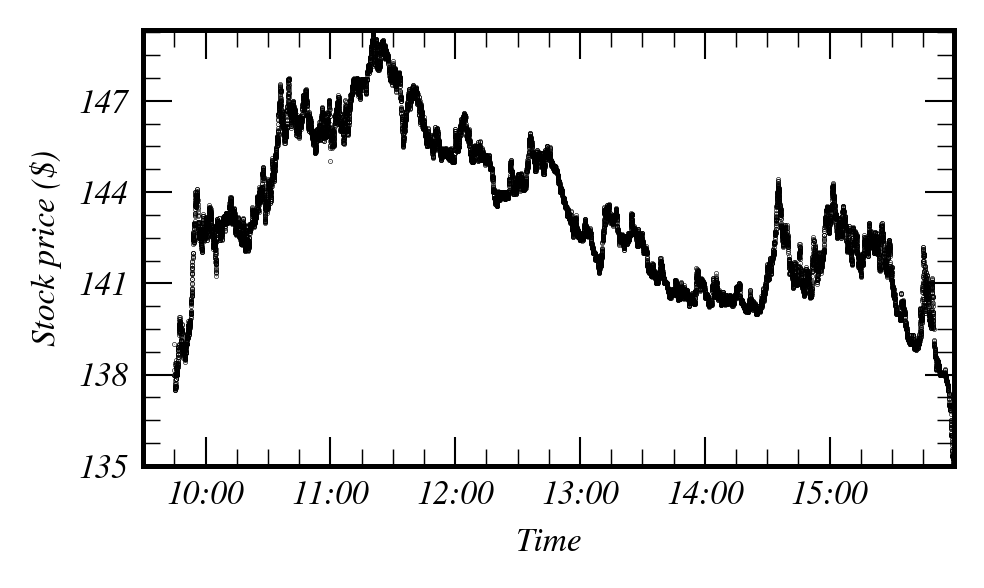

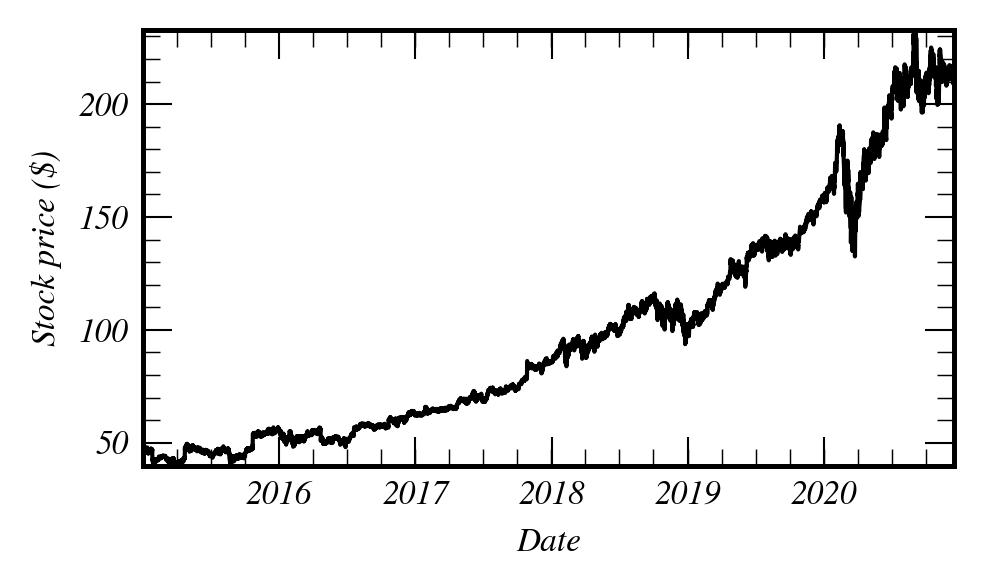

In [415]:
def plot_one_day():
    plt.figure(figsize=(3.321,2))
    plt.scatter(corona_peak.index, corona_peak.PRICE,s=0.02,color='black')
    
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.xlabel('Time')
    plt.yticks(np.arange(135,149,3))
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('MSFT_intraday.pdf')
    
    plt.show()
def plot_all():
    plt.figure(figsize=(3.321,2))
    plt.plot(df.index, df.PRICE,color='black',lw=1)
    
    plt.xlabel('Date')
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('MSFT_6years.pdf')
    plt.show()
plot_one_day()
plot_all()

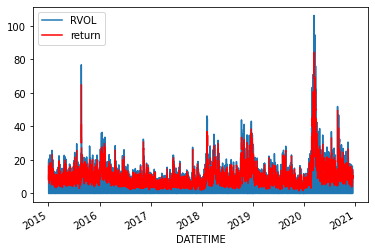

In [342]:
from scipy.stats import norm
class realized_variance():
    def __init__(self):
        self.df = pd.read_pickle('MSFT_2015_2020.pickle')
        self.df = self.df[['PRICE']].resample("5T").median() 
        self.to_returns()
        self.RV()
        self.RVOL()
        self.plot()
        return
    
    def to_returns(self):
        self.logprice = np.log(self.df[['PRICE']])
        self.returns  = (self.logprice.diff()*100).iloc[1:]
        
    def get_df(self):
        return self.returns
    
    def RV(self):
        values = self.returns#.iloc[:10000]
        values.columns = ['return']
        """values['day'] = pd.Series(values.index).apply(lambda x: pd.to_datetime(x.strftime("%Y-%m-%d"))).values
        kernel_mu  = self.returns.resample("1D").mean()
        kernel_mu.columns = ['mean']
        kernel_std = self.returns.resample("1D").std()
        kernel_std.columns = ['std']
        values = pd.merge(values,kernel_mu, left_on='day',right_index=True)
        values = pd.merge(values,kernel_std, left_on='day',right_index=True)
        
        weights = norm(values['mean'], values['std']).pdf(values['return'])"""
        weighted_return = values['return']**2 #*weights
        self.RV = weighted_return.resample("1D").sum()
        
    def RVOL(self):
        self.RVOL = np.sqrt(self.RV)
        self.RVOL = self.RVOL*np.sqrt(252)
        
    def plot(self):
        fig,ax = plt.subplots()
        ax.plot(self.RVOL,label='RVOL')
        (self.returns*100).rolling(40).std().plot(color='red',ax=ax,label='Rolling std')
        plt.legend()
        plt.show()

relvar = realized_variance()
retdf=relvar.get_df()

In [468]:
closingprices = df[['PRICE']].groupby(df.index.date).apply(lambda x: x.iloc[[-1]])
closingprices.index = closingprices.index.droplevel(0)
daily_returns = np.log(closingprices).diff().iloc[1:]

<ipython-input-481-321fd0d0fbce>:22: RuntimeWarning: invalid value encountered in log
  L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
<ipython-input-481-321fd0d0fbce>:22: RuntimeWarning: divide by zero encountered in log
  L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
<ipython-input-481-321fd0d0fbce>:22: RuntimeWarning: divide by zero encountered in true_divide
  L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
<ipython-input-481-321fd0d0fbce>:22: RuntimeWarning: invalid value encountered in subtract
  L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
<ipython-input-481-321fd0d0fbce>:14: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(params[1])
<ipython-input-481-321fd0d0fbce>:21: RuntimeWarning: invalid value encountered in double_scalars
  sigma2[t] = omega + alpha*x[t-1] + beta*sigma2[t-1]
<ipython-input-481-321fd0d0fbce>:22: RuntimeWarning: invalid value encountered in log
  L = -0.5*np.log(2*np.pi) - 0.

[0.4118001567319474, 0.2081900909709043, 0.0]


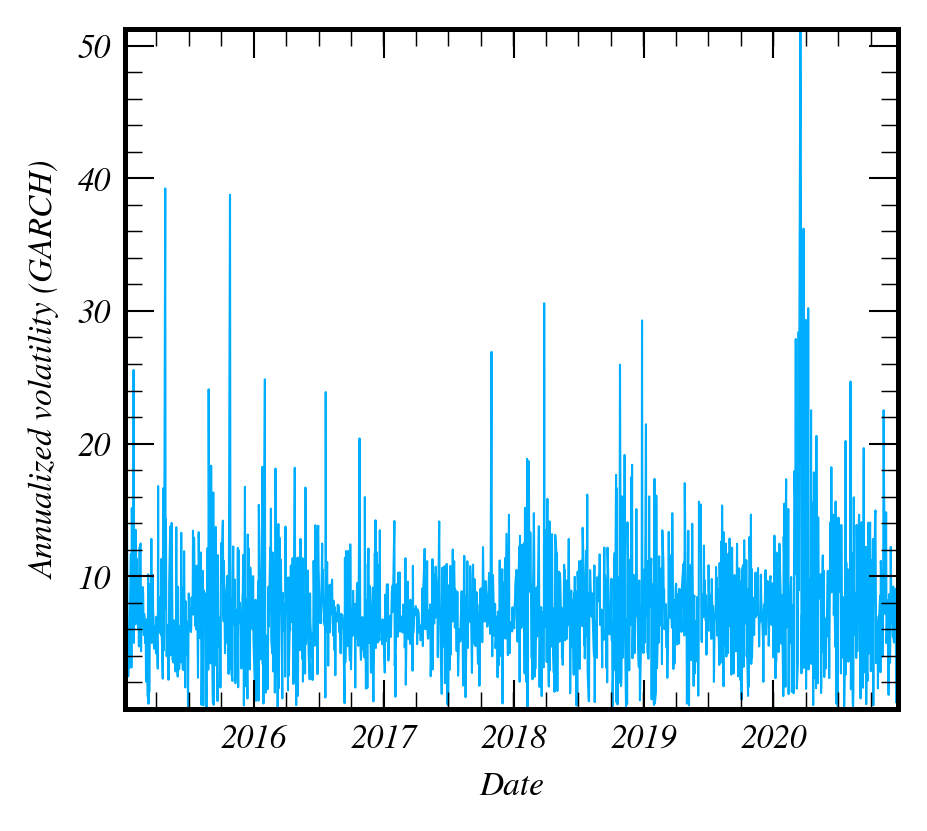

In [481]:
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self):
        self.closingreturns = daily_returns.values.flatten()*100
        # Call fit garch
        self.fit_garch(self.closingreturns)
        self.plot_vola()
        return
    
    def __llik_fun_GARCH__(self,params):
        x = self.closingreturns
        n = len(x)
        omega = np.exp(params[0])
        alpha = np.exp(params[1])
        beta  = np.exp(params[2])
        
        sigma2 = np.zeros(n)
        sigma2[0] = np.var(x)
        
        for t in range(1,n):
            sigma2[t] = omega + alpha*x[t-1] + beta*sigma2[t-1]
        L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
        llik = np.mean(L)
        return -1*llik
    
    def fit_garch(self,x):
        # Initialize values
        a = 0.2 # initial value for alpha
        b = 0.6  # initial value for beta
        omega = np.nanvar(self.closingreturns)*(1-a-b) # initial value for omega

        par_ini = np.array([np.log(omega),np.log(a/(1-a)),np.log(b/(1-b))])
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini)
        
        omega_hat = np.exp(est.x[0])
        alpha_hat = np.exp(est.x[1])/(1+np.exp(est.x[1]))
        beta_hat  = np.exp(est.x[2])/(1+np.exp(est.x[2]))
    
        self.thetahat = [omega_hat,alpha_hat,beta_hat]
        print(self.thetahat)
        
    def plot_vola(self):
        x = self.closingreturns
        n = len(x)
        omega = self.thetahat[0]
        alpha = self.thetahat[1]
        beta  = self.thetahat[2]
        sigma2 = np.zeros(n)
        sigma2[0] = np.nanvar(x)
        for t in range(1,n):
            sigma2[t] = omega + alpha*x[t-1] + beta*sigma2[t-1]
        plt.plot(daily_returns.index,np.abs(sigma2)*np.sqrt(252),lw=0.5)
        plt.xlabel('Date')
        plt.ylabel('Annualized volatility (GARCH)')
        plt.show()

Garch_func = estimate_GARCH()

In [22]:
results = []
for start in np.linspace(0,1e5,int(1e3),dtype=int):
    H=0
    h = np.arange(0,H,1,dtype=int)
    a=retdf.iloc[start:start+int(1e5)].values.flatten()
    def gamma_h(h):
        return np.sum((a*np.roll(a,h))[h:])
    gammas = np.array([gamma_h(w) for w in h])
    ks     = np.array([Parzen(w/(H+1)) for w in h])
    K = np.sum(ks*gammas)
    results.append(K)

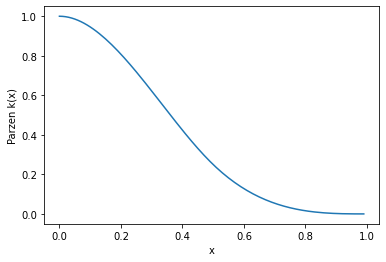

In [6]:
#######################################
###                                 ###
###    STEP 2: Daily volatility     ###
###                                 ###
#######################################
def Parzen(x):
    if 0<=x<=1/2:
        return 1-6*x**2+6*x**3
    elif 1/2<=x<=1:
        return 2*(1-x)**3
    elif x>1:
        return 0
plt.figure()
plt.plot(np.arange(-1,1,0.01),[Parzen(w) for w in np.arange(-1,1,0.01)])
plt.xlabel('x')
plt.ylabel('Parzen k(x)')
plt.show()

In [ ]:
class volatility():
    def __init__(self):
        self.timeseries = df[['PRICE']]
        return
    
    
    def Parzen(self,x):
        if 0<=x<=1/2:
            return 1-6*x**2+6*x**3
        elif 1/2<=x<=1:
            return 2*(1-x)**3
        elif x>1:
            return 0
        
    def sparse_variance(self):
        self.timeseries

In [70]:
df

,SIZE,PRICE
DATETIME,,
2015-01-02 09:30:00,759542,46.685001
2015-01-02 09:30:01,837,46.660000
2015-01-02 09:30:02,100,46.680000
2015-01-02 09:30:03,1288,46.660000
2015-01-02 09:30:04,3241,46.660000
...,...,...
2020-12-14 15:59:55,6367,214.080002
2020-12-14 15:59:56,7856,214.149994
2020-12-14 15:59:57,41730,213.800003


In [69]:
df.iloc[5:1205].PRICE.var()

0.04370105266571045

In [60]:
spx = df[['PRICE']].iloc[:1000000]

In [ ]:
spx['sqrt']= np.sqrt(spx['PRICE'])
spx['log_sqrt'] = np.log(spx['sqrt'])

In [61]:
def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

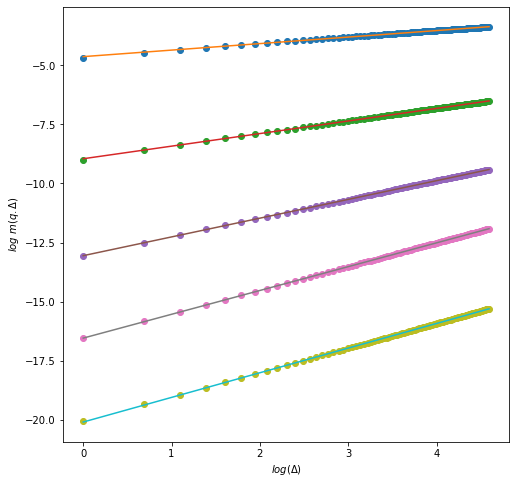

In [62]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    



0.4910107527306072


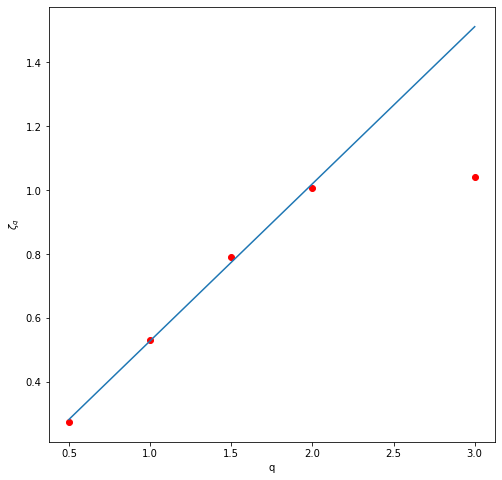

In [63]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)